# Imports

## Tensorflow Imports

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, AveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.models import load_model

## Others Imports

In [2]:
import datetime, os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import patoolib

# Descomprimir data

In [13]:
os.makedirs("data/images")

In [17]:
patoolib.extract_archive("data/images_1.rar", outdir="data/images",)

patool: Extracting data/images_1.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- D:\Trabajos\Learning\StressDetection\data\images_1.rar
patool:     with cwd=data/images
patool: ... data/images_1.rar extracted to `data/images'.


'data/images'

## Asignamos las rutas de data

In [73]:
# Definimos las rutas del dataset
train_data_dir = 'data/images/train'
val_data_dir = 'data/images/validation'

# Set Variables

In [74]:
# Definimos algunos parámetros importantes
width_shape = 48
height_shape = 48
num_classes = 4
epochs = 100
batch_size = 32
class_names = ["severo","moderado","leve","nulo"]

# Creación del modelo

## Configuramos el dataset de entrenamiento y validación

In [75]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=True)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=True)

Found 28709 images belonging to 4 classes.
Found 7178 images belonging to 4 classes.


## Creamos el modelo

In [58]:
model = Sequential()

## Extracción de Características

In [59]:
model.add(Conv2D(32,(3,3),padding = 'same',input_shape = (width_shape,height_shape,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout (0.2))

model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout (0.2))

model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


## Clasificación

In [60]:
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))


## Revisamos el modelo CNN

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)       

## Compilamos y estamos listos para el entrenamiento

In [68]:
opt = Adam(learning_rate=0.01, decay=1e-2 / epochs)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

## Configuración Tensorboard

In [69]:
%load_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Entrenamiento del modelo

In [70]:
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_steps=val_generator.n//batch_size,
    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100
250/250 [==============================] - 48s 186ms/step - loss: 1.4973 - accuracy: 0.2710 - val_loss: 1.7773 - val_accuracy: 0.2565
Epoch 2/100
250/250 [==============================] - 18s 74ms/step - loss: 1.3860 - accuracy: 0.3095 - val_loss: 1.3777 - val_accuracy: 0.2956
Epoch 3/100
185/250 [=====================>........] - ETA: 4s - loss: 1.3327 - accuracy: 0.3625

KeyboardInterrupt: 

## Guardamos el modelo

In [ ]:
model.save("/data/modelFEC_v1.h5")

## Configuración del dataset de validación sin shuffle

Found 7178 images belonging to 4 classes.
              precision    recall  f1-score   support

           0     0.3058    0.5397    0.3904      1247
           1     0.6316    0.2625    0.3709      1855
           2     0.7719    0.8081    0.7896      3007
           3     0.5907    0.5847    0.5877      1069

    accuracy                         0.5872      7178
   macro avg     0.5750    0.5488    0.5346      7178
weighted avg     0.6277    0.5872    0.5820      7178



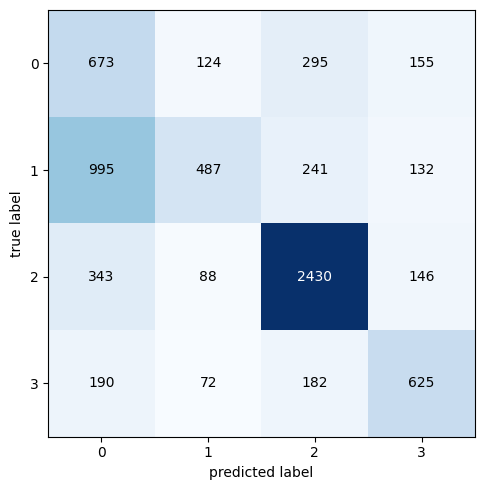

In [13]:
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=False)

predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = val_generator.classes

matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(5,5), show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

In [ ]:
%tensorboard --logdir logs